# XGBoost Hyperparameter Tuning

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 6
NUM_TREES = 25000
EARLY_STOP = 200

In [10]:
import numpy as np
import pandas as pd
import time
import os
import pyarrow
import gc

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Model/Evaluation
from IPython.display import Image
from functools import partial
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Optuna
import optuna
from optuna.pruners import PercentilePruner

# Load and Prepare Data

In [3]:
%%time

train = pd.read_feather('../data/xgboost_train.feather')
test = pd.read_feather('../data/xgboost_test.feather')
submission = pd.read_csv('../data/sample_submission.csv')

# Drop columns, cover type 5
train.drop(["Soil_Type7", "Id", "Soil_Type15"], axis=1, inplace=True)
test.drop(["Soil_Type7", "Id", "Soil_Type15"], axis=1, inplace=True)
train = train[train.Cover_Type != 5]

# Label Encoding
encoder = LabelEncoder()
train["Cover_Type"] = encoder.fit_transform(train["Cover_Type"])

Wall time: 1.59 s


# Model and Scoring Function

In [4]:
# Default XGBoost
default_params = dict(
    tree_method = 'hist',
    n_estimators = NUM_TREES,
    random_state = RANDOM_SEED,
)

In [5]:
def score_xgboost(model_params = {}, fit_params = {}):
    
    # Original Training/Test Split
    features = [x for x in train.columns if x not in ['Id','Cover_Type']]
    X_temp, X_test = train[features], test[features]
    y_temp = train['Cover_Type']
    
    # Store the out-of-fold predictions
    test_preds = np.zeros((X_test.shape[0],6))
    oof_preds = np.zeros((X_temp.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train[features],train['Cover_Type'])):
       
        # Training and Validation Sets
        start = time.time()
        X_train, X_valid = X_temp.iloc[train_idx], X_temp.iloc[valid_idx]
        y_train, y_valid = y_temp.iloc[train_idx], y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = XGBClassifier(**default_params, **model_params)
        
        model.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            eval_metric = "mlogloss",
            early_stopping_rounds = EARLY_STOP,
            verbose = 500,
            **fit_params
        )

        # validation/holdout predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        test_preds += model.predict_proba(X_test)

        # Save scores and times
        scores[fold] = accuracy_score(y_valid, valid_preds)
        end = time.time()
        
    
    test_preds = np.argmax(test_preds, axis = 1)
    oof_accuracy = accuracy_score(y_temp, oof_preds)
    print(f'OOF Accuracy: {round(100*oof_accuracy, 5)}% accuracy.')
    time.sleep(0.5)
    
    return oof_preds, test_preds

In [6]:
oof_preds, test_preds = score_xgboost({
        'max_depth': 5, 
        'learning_rate': 0.034134457831963505, 
        'gamma': 0.009393716737203944, 
        'min_child_weight': 0.05489584210577205, 
        'subsample': 0.9199999999999999, 
        'colsample_bytree': 0.5800000000000001, 
        'colsample_bylevel': 0.56, 
        'reg_lambda': 0.020044735970500934, 
        'reg_alpha': 2.7703392595849
    })

[0]	validation_0-mlogloss:1.70522
[500]	validation_0-mlogloss:0.08962
[1000]	validation_0-mlogloss:0.08117
[1500]	validation_0-mlogloss:0.07843
[2000]	validation_0-mlogloss:0.07719
[2500]	validation_0-mlogloss:0.07652
[3000]	validation_0-mlogloss:0.07613
[3500]	validation_0-mlogloss:0.07588
[4000]	validation_0-mlogloss:0.07574
[4500]	validation_0-mlogloss:0.07566
[5000]	validation_0-mlogloss:0.07560
[5500]	validation_0-mlogloss:0.07556
[6000]	validation_0-mlogloss:0.07555
[6262]	validation_0-mlogloss:0.07556
[0]	validation_0-mlogloss:1.70517
[500]	validation_0-mlogloss:0.08992
[1000]	validation_0-mlogloss:0.08135
[1500]	validation_0-mlogloss:0.07863
[2000]	validation_0-mlogloss:0.07738
[2500]	validation_0-mlogloss:0.07674
[3000]	validation_0-mlogloss:0.07634
[3500]	validation_0-mlogloss:0.07611
[4000]	validation_0-mlogloss:0.07597
[4500]	validation_0-mlogloss:0.07590
[5000]	validation_0-mlogloss:0.07586
[5500]	validation_0-mlogloss:0.07584
[6000]	validation_0-mlogloss:0.07583
[6439]	va

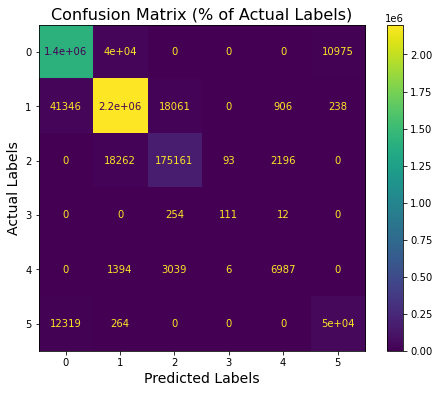

In [11]:
fig, ax = plt.subplots(figsize = (8,6))
cm = confusion_matrix(train['Cover_Type'], oof_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("Actual Labels", fontsize=14)
plt.show()

In [8]:
submission['Cover_Type'] = encoder.inverse_transform(test_preds)
submission.to_csv('../output/xgboost_submission.csv')